# Dogs vs Cats – Image Classification with CNN (Keras & TensorFlow)

This notebook builds an image classification model to distinguish between **dogs** and **cats** using the Kaggle *Dogs vs Cats* dataset.  
The workflow covers the full deep-learning pipeline:

1. **Data loading & splitting**  
   - Download the dataset from Kaggle.  
   - Build a `DataFrame` with image `filename` and `category` (`dog` / `cat`).  
   - Split into training and validation sets.

2. **Image preprocessing & augmentation**  
   - Use `ImageDataGenerator` to rescale pixel values and apply data augmentation  
     (rotation, zoom, shifts, flips, etc.) to improve generalization.

3. **Model architecture**  
   - Build a Convolutional Neural Network (CNN) in Keras for binary classification.  
   - Stack convolution, pooling and dense layers with nonlinear activations and dropout.

4. **Training & evaluation**  
   - Train the model on the training generator and monitor performance on the validation set.  
   - Plot learning curves (accuracy & loss) and inspect predictions on sample images.

5. **Inference**  
   - Use the trained model to predict whether new images contain a dog or a cat.

This notebook can be used as a complete end-to-end example of an image-classification pipeline in TensorFlow/Keras on a real-world dataset.


### **Reading Data From Kaggle**

In [68]:
#from google.colab import files
#files.upload()  # ارفع kaggle.json هنا


In [2]:
#!mkdir ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json


In [69]:
#!kaggle datasets download -d biaiscience/dogs-vs-cats



In [71]:
#!mkdir data
#!unzip dogs-vs-cats.zip -d data


In [70]:
#!ls data/train
#!ls data/test


### **Importing Libraries**

In [6]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import cv2
import warnings
from warnings import filterwarnings
filterwarnings('ignore')

### **Define Constants**


In [7]:
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [8]:
train_path = "/content/data/train/train"
test_path  = "/content/data/test/test"


### **Prepare Traning Data**


In [9]:
train_len = len(os.listdir(train_path))
print(train_len)


25000


### **Labling Data**


In [10]:
filenames = os.listdir(train_path)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'cat':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [11]:
df.head()

,filename,category
0,dog.9638.jpg,0
1,dog.10492.jpg,0
2,cat.562.jpg,1
3,cat.11045.jpg,1
4,dog.9582.jpg,0


In [12]:
df.tail()

,filename,category
24995,dog.643.jpg,0
24996,dog.11455.jpg,0
24997,cat.11777.jpg,1
24998,dog.6637.jpg,0
24999,dog.1182.jpg,0


In [13]:
df['category'].value_counts()  # 500 for each class

,count
category,
0,12500
1,12500


### **Display Images**


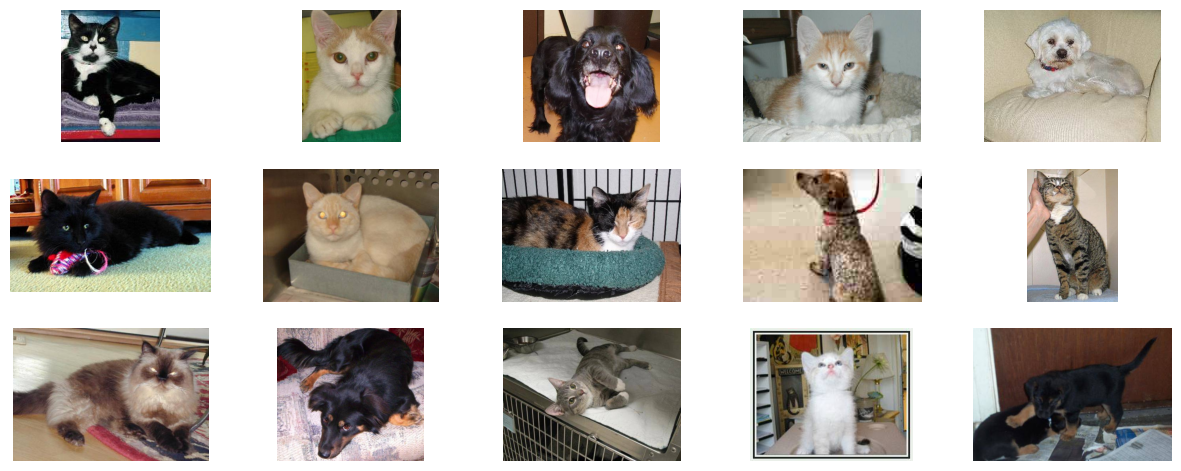

In [14]:
plt.figure(figsize=(15, 10))
for n, i in enumerate(np.random.randint(0, len(filenames), 15)):
    plt.subplot(5, 5, n + 1)
    sample = filenames[i]
    image_path = os.path.join(train_path, sample)
    image = load_img(image_path)
    plt.imshow(image)
    plt.axis('off')
plt.show()

### **Building CNN Model**

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>


In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(
        IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2, 2),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2, 2),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2, 2),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='tanh'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),


])

In [16]:
model.compile(optimizer="adam", loss="binary_crossentropy",
              metrics=["accuracy"])

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,533,441 (24.92 MB)

 Trainable params: 6,532,993 (24.92 MB)

 Non-trainable params: 448 (1.75 KB)

### **Callbacks**

**Early Stop**

**To prevent overfitting we will stop the learning after 10 epochs and val_loss value not decreased**


In [18]:
Earlystop = EarlyStopping(
    patience=10, monitor='val_accuracy', restore_best_weights=True)

In [19]:
callbacks = Earlystop

### **Preparing Data**

We will use image genarator **with class_mode="Binary"**.So We need to convert **category** into string. Then imagenerator will convert it

So we will convert 0 to cat and 1 to dog


In [20]:
df["category"] = df["category"].replace({1: 'cat', 0: 'dog'})

### **Splitting Data**


In [21]:

train_df, test_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [22]:
train_df.head()

,filename,category
0,dog.11138.jpg,dog
1,dog.9187.jpg,dog
2,cat.4225.jpg,cat
3,cat.11077.jpg,cat
4,cat.438.jpg,cat


In [23]:
print('train_df Shape is : ', train_df.shape)
print("="*36)
print('test_df Shape is : ', test_df.shape)

train_df Shape is :  (20000, 2)
test_df Shape is :  (5000, 2)


In [24]:
train_df['category'].value_counts()

,count
category,
dog,10056
cat,9944


In [25]:
test_df['category'].value_counts()

,count
category,
cat,2556
dog,2444


In [40]:
batch_size =32

### **Data Augmentation**


#### **Training**


In [41]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [42]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    train_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


#### **Testing**


In [43]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [44]:
testing_generator = test_datagen.flow_from_dataframe(
    test_df,
    train_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


### **Display Random Image After Generator**


Found 1 validated image filenames.


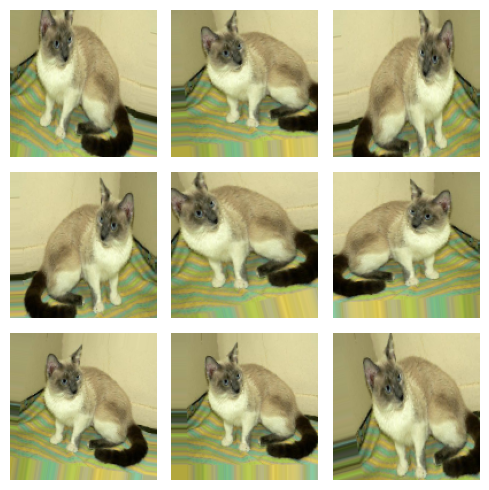

In [45]:
image_df = train_df.sample(n=1).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe(
    image_df,
    directory=train_path,
    x_col='filename',
    y_col=None,
    target_size=IMAGE_SIZE,
    class_mode=None,
    shuffle=False
)

plt.figure(figsize=(5, 5))
for i in range(9):
    X_batch = next(example_generator)
    img = X_batch[0]
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

### **Fitting The Model**


In [46]:
epochs = 50
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=testing_generator,
    callbacks=callbacks,
    verbose=1,

)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 115s 185ms/step - accuracy: 0.7059 - loss: 0.5665 - val_accuracy: 0.6974 - val_loss: 0.5708
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 112s 178ms/step - accuracy: 0.7002 - loss: 0.5655 - val_accuracy: 0.6546 - val_loss: 0.6179
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 105s 168ms/step - accuracy: 0.7033 - loss: 0.5608 - val_accuracy: 0.7052 - val_loss: 0.5549
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 111s 178ms/step - accuracy: 0.7149 - loss: 0.5452 - val_accuracy: 0.7224 - val_loss: 0.5383
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 106s 169ms/step - accuracy: 0.7158 - loss: 0.5441 - val_accuracy: 0.6830 - val_loss: 0.5900
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 106s 169ms/step - accuracy: 0.7252 - loss: 0.5373 - val_accuracy: 0.7382 - val_loss: 0.5210
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 173ms/step - accuracy: 0.7376 - loss: 0.5199 - val_accuracy: 0.7466 - val_loss: 0.5040
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 107s 172ms/step - accuracy: 0.7463 -

### **Saving Model**


In [47]:

model.save("CNN.model.keras")

In [48]:
CNN_Model = keras.models.load_model("CNN.model.keras")

### **Evaluation**


In [49]:

# 3) Predict on the whole testing generator
y_pred = CNN_Model.predict(testing_generator)
print("Prediction Shape is {}".format(y_pred.shape))

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step
Prediction Shape is (5000, 1)


In [50]:

# 4) Get one batch from the training generator
X_batch, y_batch = next(train_generator)

# 5) Predictions for that batch
batch_pred = CNN_Model.predict(X_batch)


# 6) Convert sigmoid output to binary 0/1  (binary classification)
y_pred_classes = (batch_pred > 0.5).astype("int32").reshape(-1)
y_true = y_batch.reshape(-1)


print("Predicted labels:", y_pred_classes[:20])
print("True labels:     ", y_true[:20])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
Predicted labels: [0 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0 0 1]
True labels:      [0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1.]


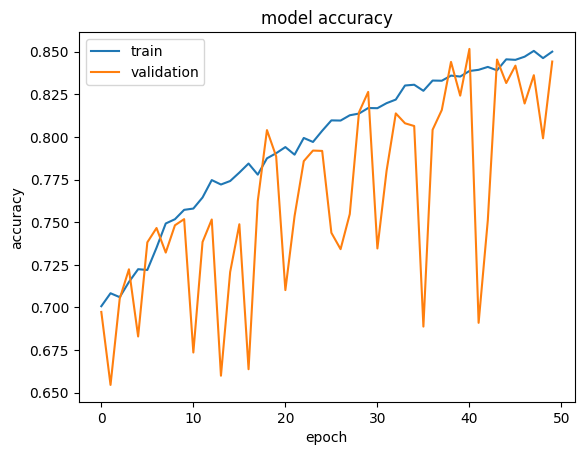

In [51]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

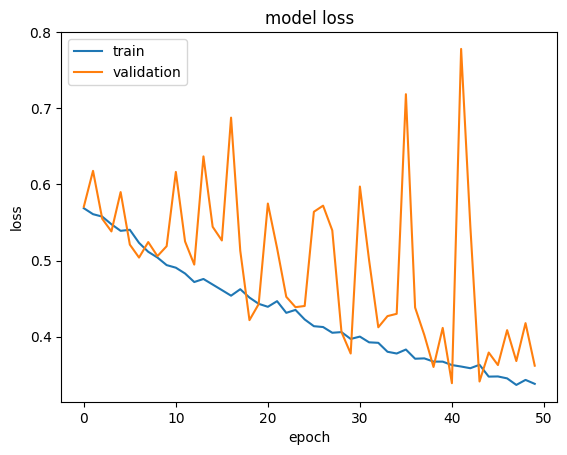

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Prepare Validation Data**


In [53]:
valid_filenames = os.listdir(test_path)
valid_df = pd.DataFrame({'filename': valid_filenames})
nb_samples = valid_df.shape[0]
nb_samples

12500

### **Create Validation Generator**


In [54]:
valid_gen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_gen.flow_from_dataframe(
    valid_df,
    test_path,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


### **Prediction**


In [55]:

pred = CNN_Model.predict(valid_generator, verbose=1)

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step


In [56]:
pred_classes = (pred > 0.5).astype(int).reshape(-1)  # 0 or 1

In [57]:
label_map = {0: "cat", 1: "dog"}
pred_labels = [label_map[i] for i in pred_classes]

In [59]:
import cv2

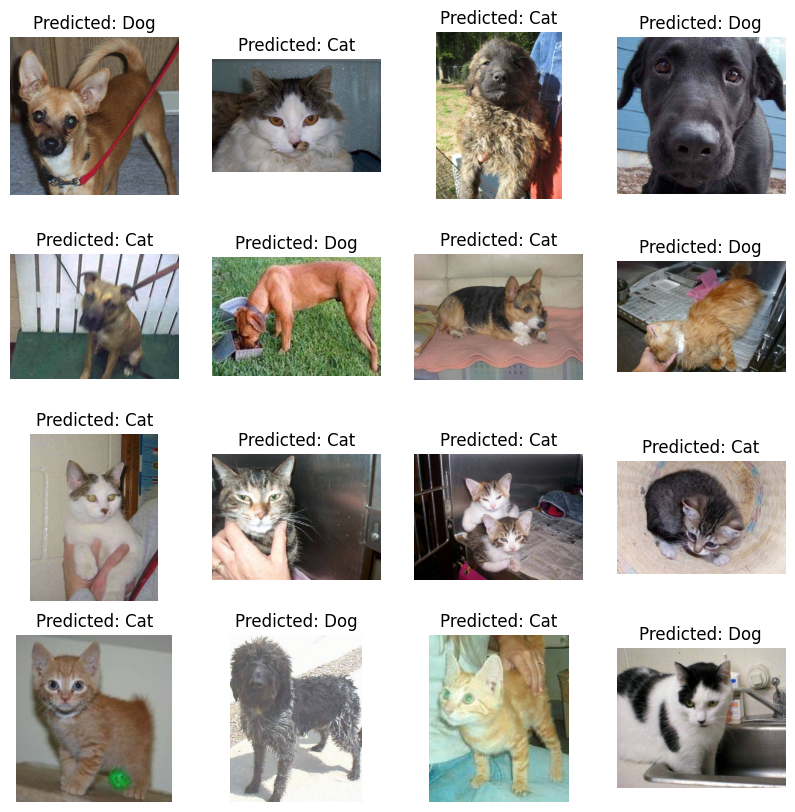

In [72]:
f, ax = plt.subplots(4, 4, figsize=(10, 10))

for idx in range(16):
    filename = valid_generator.filenames[idx]   # e.g. "cats/cat.123.jpg"
    full_path = os.path.join(test_path, filename)

    imgBGR = cv2.imread(full_path)
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

    predicted_class = "Dog" if pred_classes[idx] == 1 else "Cat"

    ax[idx // 4, idx % 4].imshow(imgRGB)
    ax[idx // 4, idx % 4].axis("off")
    ax[idx // 4, idx % 4].set_title(f"Predicted: {predicted_class}")

plt.show()


In [67]:
print(train_generator.class_indices)

{'cat': 0, 'dog': 1}
